In [82]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models import resnet34

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, confusion_matrix

from train import group_max, group_argtopk
from dataset import MILdataset

In [2]:
np.set_printoptions(linewidth=150, suppress=True)

## Load model

In [3]:
model = resnet34(num_classes=6)

In [4]:
# load checkpoint
ckpt = '~/Downloads/projects/prostate-cancer-grade-assessment/runs/Jul10_21-36-05_instance-3/checkpoint_best.pt'
model.load_state_dict(torch.load(ckpt, map_location='cpu')['model_state'])
model.eval();

In [5]:
df = pd.read_csv('./data/train.csv').set_index('image_id').sort_index()
df.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [6]:
ds = MILdataset('./data/train_images/tiles_overlap_0/', df)
ds.set_mode('eval')
print('dataset length:', len(ds))

Dataset construction mismatch.
dataset length: 500


In [7]:
img_avg = np.loadtxt('./kaggle-datasets/ckpts/img_avg.txt')
img_std  = np.loadtxt('./kaggle-datasets/ckpts/img_std.txt')
ds.transform = T.Compose([T.ToTensor(), T.Normalize(img_avg, img_std)])

In [8]:
idxs_to_eval = np.where(ds.slide_idxs == 5)[0]
idxs_to_eval

array([202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223])

In [9]:
img_id = ds.tiles[idxs_to_eval[0]].rpartition('/')[2].split('_')[0]
label = df.loc[img_id].isup_grade
print('ground truth:\n', df.loc[img_id])

ground truth:
 data_provider    radboud
isup_grade             4
gleason_score        4+4
Name: 07a14fa5b8f74272e4cc0a439dbc8f7f, dtype: object


In [10]:
logits = []
ds.set_mode('eval')
model.eval()
with torch.no_grad():
    for i in idxs_to_eval:
        x = ds[i].unsqueeze(0)
        logits.append(model(x))
logits = torch.cat(logits)

In [11]:
logits.shape

torch.Size([22, 6])

In [12]:
probs = F.softmax(logits, 1).numpy()

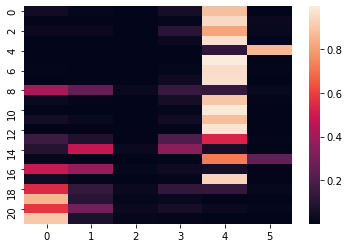

In [13]:
sns.heatmap(probs);

# Losses

For slide 07a14fa5b8f74272e4cc0a439dbc8f7f <br>
correct label is 4 <br>
tile_idx 3 predicts label 4 --- correctly classified as in tile label matches slide label => want no loss here<br>
tile_idx 4 predicts wrong label 5 --- (false positive) no tiles in bag should be classified above slide label => want loss here <br>
tile_idx 21 predicts label 0 --- could be true for healthy tile and otherwise unhealthy slide => want loss here if no other tile has higher class and no loss here if other tiles with higher class exist for this slide <br>

During training, select tile with highest class with prob > 50%. So if I have a tile with class > target, it will be selected into training set and will lead to high loss. <br>
Conversely, if I have a tile with class < target: <br>
* option a: tile is selected when no other tile has class >= target, then I want loss to push tile up
* option b: tile is not selected because some other tile with class >= target is selected, so no loss from this tile

In [33]:
print('logits at tile idx 3 (correct)     : ', logits[3].numpy().round(3))
print('logits at tile idx 4 (wrong above) : ', logits[4].numpy().round(3))
print('logits at tile idx 21              : ', logits[21].numpy().round(3))
print('-------')
print('softmax probs at tile idx 3 (correct)     : ', F.softmax(logits[3], 0).numpy().round(3))
print('softmax probs at tile idx 4 (wrong above) : ', F.softmax(logits[4], 0).numpy().round(3))
print('softmax probs at tile idx 21              : ', F.softmax(logits[21], 0).numpy().round(3))
print('-------')
print('sigmoid probs at tile idx 3 (correct)     : ', F.sigmoid(logits[3]).numpy().round(3))
print('sigmoid probs at tile idx 4 (wrong above) : ', F.sigmoid(logits[4]).numpy().round(3))
print('sigmoid probs at tile idx 21              : ', F.sigmoid(logits[21]).numpy().round(3))

logits at tile idx 3 (correct)     :  [-2.041 -1.931 -3.198  0.866  4.581 -0.354]
logits at tile idx 4 (wrong above) :  [-1.39  -2.454 -4.186 -1.25   2.627  4.553]
logits at tile idx 21              :  [ 3.891  1.362 -0.435 -0.808 -1.989 -2.518]
-------
softmax probs at tile idx 3 (correct)     :  [0.001 0.001 0.    0.024 0.966 0.007]
softmax probs at tile idx 4 (wrong above) :  [0.002 0.001 0.    0.003 0.127 0.868]
softmax probs at tile idx 21              :  [0.904 0.072 0.012 0.008 0.003 0.001]
-------
sigmoid probs at tile idx 3 (correct)     :  [0.115 0.127 0.039 0.704 0.99  0.412]
sigmoid probs at tile idx 4 (wrong above) :  [0.199 0.079 0.015 0.223 0.933 0.99 ]
sigmoid probs at tile idx 21              :  [0.98  0.796 0.393 0.308 0.12  0.075]


#### CE

Optimize for high probability at the correct slide label.

In [85]:
loss = - F.log_softmax(logits, 1)[:, label]
assert torch.allclose(loss, F.cross_entropy(logits, label * torch.ones(len(logits)).long(), reduction='none'))
print('loss at tile idx 3 : ', loss[3])
print('loss at tile idx 4 : ', loss[4])
print('loss at tile idx 21: ', loss[21])

loss at tile idx 3 :  tensor(0.0342)
loss at tile idx 4 :  tensor(2.0672)
loss at tile idx 21:  tensor(5.9810)


#### Masked BCE

Should only take loss for labels above the target label: e.g. loss is [0.1, 0.2, 0.3] and target label is 1, then take 0.3 and ignore entries 0.1 and 0.2

In [114]:
bce_label = torch.from_numpy(np.arange(6) <= label).repeat(len(logits),1).float()
print('bce label: ', bce_label[0])
loss = F.binary_cross_entropy_with_logits(logits, bce_label, reduction='none')
print('loss at tile idx 3 : ', loss[3])
print('loss at tile idx 4 : ', loss[4])
print('loss at tile idx 21: ', loss[21])
print('-----')
print('mean loss at tile idx 3 : ', loss.mean(1)[3])
print('mean loss at tile idx 4 : ', loss.mean(1)[4])
print('mean loss at tile idx 21: ', loss.mean(1)[21])
print('-----')
mask = bce_label.cumsum(1) == bce_label.cumsum(1).max(1, keepdim=True).values  # only count loss at target class and any classes above target class
print('mask: ', mask[0])
print('masked loss at tile idx 3 : ', (loss * mask)[3])
print('masked loss at tile idx 4 : ', (loss * mask)[4])
print('masked loss at tile idx 21: ', (loss * mask)[21])

bce label:  tensor([1., 1., 1., 1., 1., 0.])
loss at tile idx 3 :  tensor([2.1630, 2.0662, 3.2380, 0.3512, 0.0102, 0.5316])
loss at tile idx 4 :  tensor([1.6122, 2.5366, 4.2008, 1.5018, 0.0698, 4.5631])
loss at tile idx 21:  tensor([0.0202, 0.2280, 0.9340, 1.1769, 2.1168, 0.0775])
-----
mean loss at tile idx 3 :  tensor(1.3933)
mean loss at tile idx 4 :  tensor(2.4140)
mean loss at tile idx 21:  tensor(0.7589)
-----
mask:  tensor([False, False, False, False,  True,  True])
masked loss at tile idx 3 :  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0102, 0.5316])
masked loss at tile idx 4 :  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0698, 4.5631])
masked loss at tile idx 21:  tensor([0.0000, 0.0000, 0.0000, 0.0000, 2.1168, 0.0775])


#### MultiMargin

This could cause problems with my training set tile selection taking tiles from highest class with prob >= 0.5. Prob 0.5 becomes meaningless with the margin loss on it own.

In [629]:
loss = F.multi_margin_loss(logits, label * torch.ones(len(logits)).long(), reduction='none')
print('loss at tile idx 3 : ', loss[3])
print('loss at tile idx 4 : ', loss[4])
print('loss at tile idx 21: ', loss[21])
print('-----')
loss_components = np.maximum(0, 1 - logits[:,label].numpy()[:,None] + np.delete(logits.numpy(), label, axis=1))
print('loss components at tile idx 3 : ', loss_components[3])
print('loss components at tile idx 4 : ', loss_components[4])
print('loss components at tile idx 21: ', loss_components[21])
print('-----')
mask = 1 - np.tile(np.hstack([np.ones(label), np.zeros(6 - label - 1)]), (len(logits), 1)).astype(np.float32)
print(mask[0])
print('masked loss components at tile idx 3 : ', (loss_components * mask)[3])
print('masked loss components at tile idx 4 : ', (loss_components * mask)[4])
print('masked loss components at tile idx 21: ', (loss_components * mask)[21])

loss at tile idx 3 :  tensor(0.)
loss at tile idx 4 :  tensor(0.4875)
loss at tile idx 21:  tensor(2.7392)
-----
loss components at tile idx 3 :  [0. 0. 0. 0. 0.]
loss components at tile idx 4 :  [0.        0.        0.        0.        2.9252732]
loss components at tile idx 21:  [6.879841   4.3508034  2.5537028  2.1801994  0.47050428]
-----
[0. 0. 0. 0. 1.]
masked loss components at tile idx 3 :  [0. 0. 0. 0. 0.]
masked loss components at tile idx 4 :  [0.        0.        0.        0.        2.9252732]
masked loss components at tile idx 21:  [0.         0.         0.         0.         0.47050428]


# Confusion matrix at loss function

What is loss at lower left and upper right corner of cm
<br>
pretend the preds above are for different slides; look at cm

In [95]:
preds = logits.argmax(1)
cm = confusion_matrix(label * np.ones(len(logits)), preds)

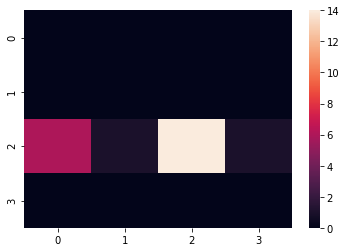

In [96]:
sns.heatmap(cm)

In [115]:
loss = torch.sum(loss * mask, 1)

In [116]:
loss.masked_select(preds == 0).mean()

tensor(1.4346)

In [117]:
loss.masked_select(preds == 1)

tensor([0.5810])

In [118]:
loss.masked_select(preds == 5)

tensor([4.6329])